# Step 1: Setup and Imports

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist

Using TensorFlow backend.


# Step 2: Load and Visualize Fashion MNIST Dataset

4423680/4422102 [==============================] - 0s 0us/step


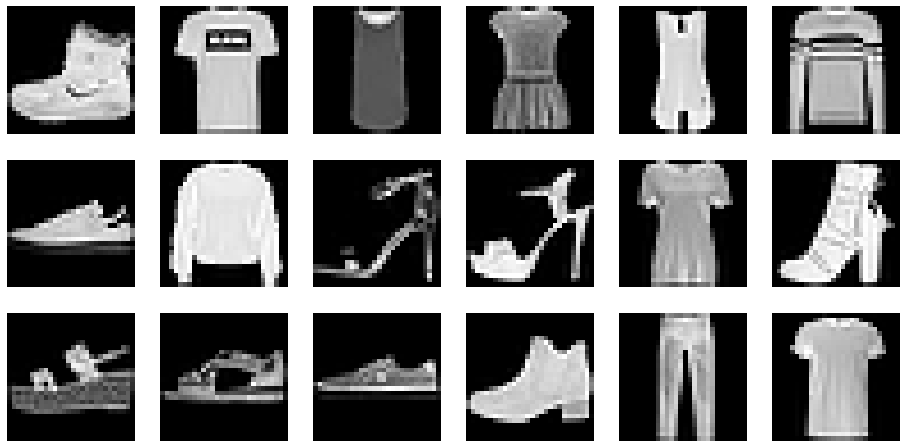

[9 0 0 3 0 2 7 2 5 5]


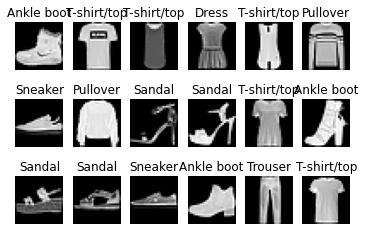

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

print(y_train[0:10])

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(id_to_labels[y_train[i]])
    plt.axis("off")
plt.show()

# Step 3: Prepare Data for Fully-Connected VAE

(60000, 784) (10000, 784)


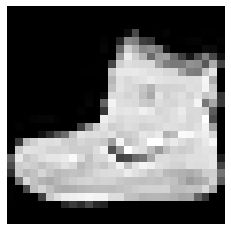

In [4]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_standard.shape, x_test_standard.shape)

plt.imshow(x_train_standard[0].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()

# Step 4: Build the Fully-Connected VAE

## 4.1 Define the Encoder

In [5]:
original_dim = 784
intermediate_dim = 256
latent_dim = 2

def make_encoder(original_dim, intermediate_dim, latent_dim):
    x = Input(shape=(original_dim,))
    hidden = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)
    return Model(inputs=x, outputs=[z_mean, z_log_var], name="mlp_encoder")

encoder = make_encoder(original_dim, intermediate_dim, latent_dim)
print(encoder.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "mlp_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
Total p

## 4.2 Define the Sampling Layer

In [6]:
def sampling_func(inputs):
    z_mean, z_log_var = inputs
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,), name="latent_sampler")

## 4.3 Define the Decoder

In [7]:
def make_decoder(latent_dim, intermediate_dim, original_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(original_dim, activation='sigmoid')(x)
    return Model(decoder_input, x, name="mlp_decoder")

decoder = make_decoder(latent_dim, intermediate_dim, original_dim)
print(decoder.summary())

Model: "mlp_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________
None


## 4.4 Test the Untrained Decoder

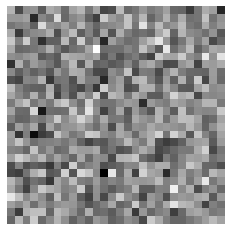

In [8]:
random_z_from_prior = np.random.normal(loc=0, scale=1, size=(1, latent_dim))
generated = decoder.predict(random_z_from_prior)
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## 4.5 Build the Full VAE

In [9]:
def make_vae(input_shape, encoder, decoder, sampling_layer):
    x = Input(shape=input_shape, name="input")
    z_mean, z_log_var = encoder(x)
    z = sampling_layer([z_mean, z_log_var])
    x_decoded_mean = decoder(z)
    vae = Model(x, x_decoded_mean)

    xent_loss = original_dim * metrics.binary_crossentropy(
        K.flatten(x), K.flatten(x_decoded_mean))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

vae = make_vae((original_dim,), encoder, decoder, sampling_layer=sampling_layer)
print(vae.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
mlp_encoder (Model)             [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
latent_sampler (Lambda)         (None, 2)            0           mlp_encoder[1][0]                
                                                                 mlp_encoder[1][1]                
__________________________________________________________________________________________________
mlp_decoder (Model)             (None, 784)          202256      latent_sampler[0][0]       

c:\users\kerem\github\python-keras-deep-learning\advml\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output mlp_decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to mlp_decoder.
  'be expecting any data to be passed to {0}.'.format(name))


# Step 5: Train the Fully-Connected VAE (or Load Weights)

In [12]:
# vae.fit(x_train_standard, epochs=50, batch_size=100, validation_data=(x_test_standard, None))
vae.load_weights("Files/standard_weights.h5")

# Step 6: Generate and Visualize Samples from the Trained Fully-Connected VAE

## 6.1 Generate Random Samples

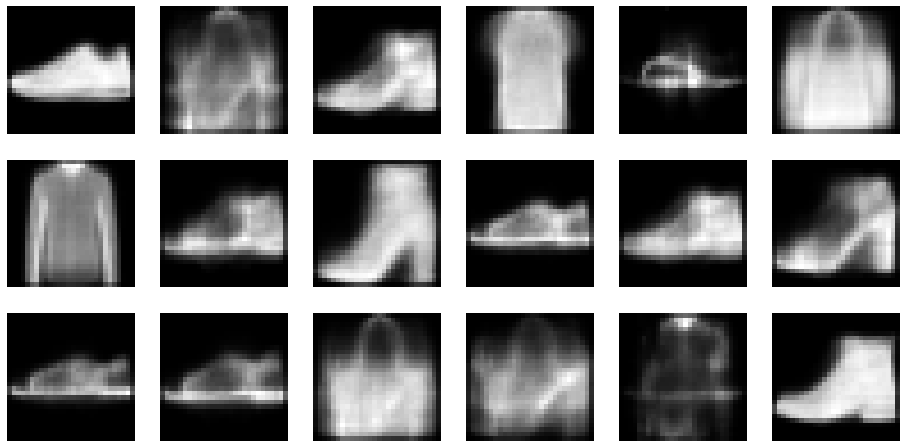

In [13]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    random_z_from_prior = np.random.normal(size=(1, latent_dim))
    generated = decoder.predict(random_z_from_prior)
    plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

## 6.2 Visualize the Latent Space

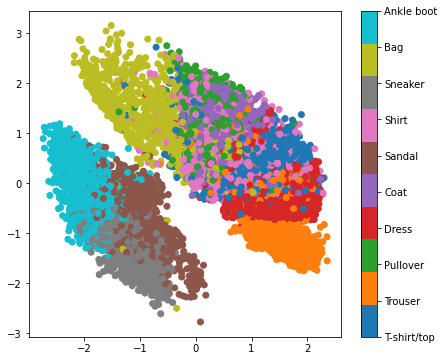

In [14]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

x_test_encoded, x_test_encoded_log_var = encoder.predict(x_test_standard, batch_size=100)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

## 6.3 Visualize the Latent Manifold

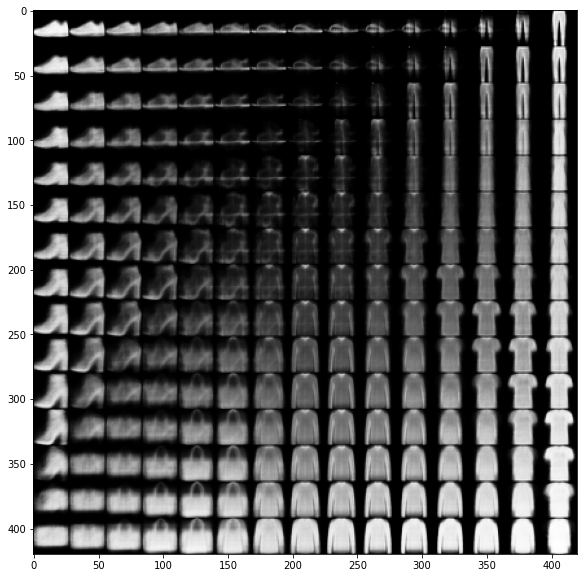

In [15]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Step 7: Build the Convolutional VAE

## 7.1 Prepare Data for Convolutional VAE

In [16]:
x_train_conv = np.expand_dims(x_train, -1)
x_test_conv = np.expand_dims(x_test, -1)
print(x_train_conv.shape, x_test_conv.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## 7.2 Define the Convolutional Encoder

In [17]:
from keras.layers import BatchNormalization

img_rows, img_cols, img_chns = 28, 28, 1
filters = 32
kernel_size = 3
intermediate_dim = 128
latent_dim = 2

def make_conv_encoder(img_rows, img_cols, img_chns, latent_dim, intermediate_dim):
    inp = x = Input(shape=(img_rows, img_cols, img_chns))
    x_conv = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu', strides=(2, 2))(x_conv)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu')(x_conv)
    x_conv = BatchNormalization()(x_conv)
    x_conv = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu', strides=(2, 2))(x_conv)
    flat = Flatten()(x_conv)
    hidden = Dense(intermediate_dim, activation='relu')(flat)
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden)
    return Model(inputs=inp, outputs=[z_mean, z_log_var], name='convolutional_encoder')

conv_encoder = make_conv_encoder(img_rows, img_cols, img_chns, latent_dim, intermediate_dim)
print(conv_encoder.summary())

Model: "convolutional_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   9248        batch_normalization_1[0][0]      
______________________________________________________________________________

## 7.3 Reuse the Sampling Layer (4.2 Define the Sampling Layer)

In [18]:
def sampling_func(inputs):
    z_mean, z_log_var = inputs
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

sampling_layer = Lambda(sampling_func, output_shape=(latent_dim,), name="latent_sampler")

## 7.4 Define the Convolutional Decoder

In [19]:
def make_conv_decoder(latent_dim, intermediate_dim, original_dim, spatial_size=7, filters=16):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(intermediate_dim, activation='relu')(decoder_input)
    x = Dense(filters * spatial_size * spatial_size, activation='relu')(x)
    x = Reshape((spatial_size, spatial_size, filters))(x)
    x = Conv2DTranspose(filters, kernel_size=3, padding='same', strides=(2, 2), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters, kernel_size=3, padding='same', strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters, kernel_size=3, strides=(2, 2), padding='valid', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, kernel_size=2, padding='valid', activation='sigmoid')(x)
    return Model(decoder_input, x, name='convolutional_decoder')

conv_decoder = make_conv_decoder(latent_dim, intermediate_dim, original_dim, spatial_size=7, filters=filters)
print(conv_decoder.summary())

Model: "convolutional_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_10 (Dense)             (None, 1568)              202272    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 3

## 7.5 Test the Untrained Decoder

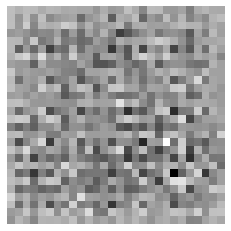

In [20]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## 7.6 Build the Full Convolutional VAE

In [21]:
input_shape = (img_rows, img_cols, img_chns)
vae = make_vae(input_shape, conv_encoder, conv_decoder, sampling_layer)
print(vae.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
convolutional_encoder (Model)   [(None, 2), (None, 2 229796      input[0][0]                      
__________________________________________________________________________________________________
latent_sampler (Lambda)         (None, 2)            0           convolutional_encoder[1][0]      
                                                                 convolutional_encoder[1][1]      
__________________________________________________________________________________________________
convolutional_decoder (Model)   (None, 28, 28, 1)    230913      latent_sampler[0][0]       

c:\users\kerem\github\python-keras-deep-learning\advml\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output convolutional_decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to convolutional_decoder.
  'be expecting any data to be passed to {0}.'.format(name))


# Step 8: Train the Convolutional VAE (or Load Weights)

In [23]:
# vae.fit(x_train_conv, epochs=15, batch_size=100, validation_data=(x_test_conv, None))
vae.load_weights("Files/convolutional_weights.h5")

# Step 9: Generate and Visualize Samples from the Trained Convolutional VAE

## 9.1 Generate a Random Sample

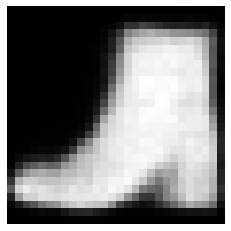

In [24]:
generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## 9.2 Visualize the Latent Space

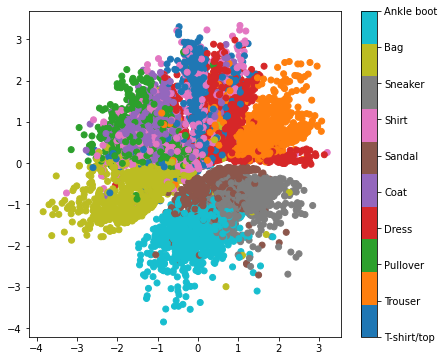

In [25]:
x_test_encoded, _ = conv_encoder.predict(x_test_conv, batch_size=100)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

## 9.3 Visualize the Latent Manifold

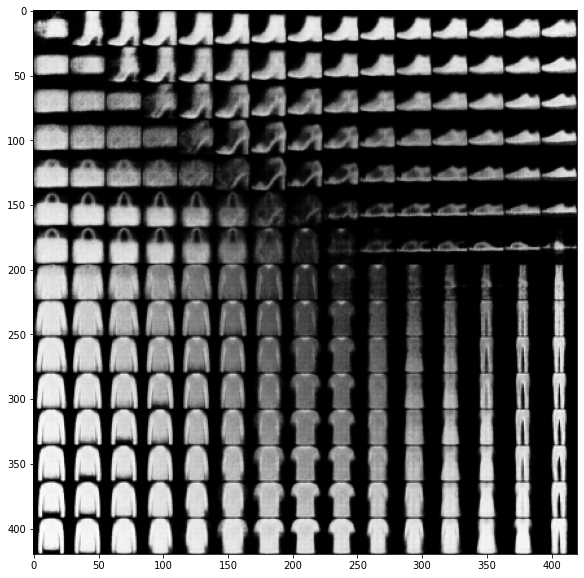

In [26]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = conv_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Step 10: Extensions and Experiments

## 1. Quantitative Comparison

In [28]:
def compute_reconstruction_loss(model, x_test):
    x_reconstructed = model.predict(x_test)
    x_test_flat = K.flatten(x_test)
    x_reconstructed_flat = K.flatten(x_reconstructed)
    return K.eval(original_dim * metrics.binary_crossentropy(x_test_flat, x_reconstructed_flat))

# For fully-connected VAE
vae_standard = make_vae((original_dim,), encoder, decoder, sampling_layer)
vae_standard.load_weights("Files/standard_weights.h5")
loss_standard = compute_reconstruction_loss(vae_standard, x_test_standard)

# For convolutional VAE
vae_conv = make_vae((img_rows, img_cols, img_chns), conv_encoder, conv_decoder, sampling_layer)
vae_conv.load_weights("Files/convolutional_weights.h5")
loss_conv = compute_reconstruction_loss(vae_conv, x_test_conv)

print("Fully-Connected VAE Loss:", loss_standard)
print("Convolutional VAE Loss:", loss_conv)

Fully-Connected VAE Loss: 256.40198
Convolutional VAE Loss: 253.1764


## 2. Interpolate in Latent Space

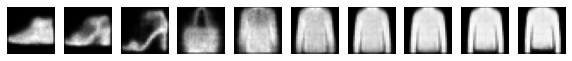

In [29]:
# For convolutional VAE
idx1, idx2 = 0, 1
z1, _ = conv_encoder.predict(x_test_conv[idx1:idx1+1])
z2, _ = conv_encoder.predict(x_test_conv[idx2:idx2+1])
n_steps = 10
plt.figure(figsize=(n_steps, 1))
for i, alpha in enumerate(np.linspace(0, 1, n_steps)):
    z_interp = (1 - alpha) * z1 + alpha * z2
    x_interp = conv_decoder.predict(z_interp)
    plt.subplot(1, n_steps, i + 1)
    plt.imshow(x_interp.reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

## 3. Denoising VAE

In [33]:
noise_factor = 0.5
x_train_noisy = x_train_conv + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_conv.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = x_test_conv + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_conv.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

vae.fit(x_train_noisy, epochs=1, batch_size=100, validation_data=(x_test_noisy, None)) # epochs could be higher

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 127s 2ms/step - loss: 467.9766 - val_loss: 461.2746


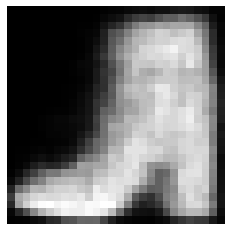

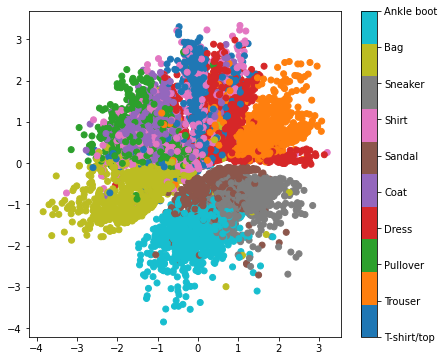

In [34]:
vae.load_weights("Files/convolutional_weights.h5")

generated = conv_decoder.predict(np.random.normal(size=(1, latent_dim)))
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');
plt.show()

# ### 2D plot of the image classes in the latent space
x_test_encoded, _ = conv_encoder.predict(x_test_conv, batch_size=100)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()